# Spatial mapping of cell types across the mouse brain (extra) - illustration video

This notebook demonstrates how to use the **cell2location** model for mapping a single cell transcriptomic reference onto a spatial transcriptomic dataset. Here, we use a 10X single nucleus RNA-sequencing (snRNAseq) and Visium spatial transcriptomic data generated from adjacent tissue sections of the mouse brain (Kleshchevnikov et al., in preparation). 

cell2location is a Bayesian model that integrates single-cell RNA-seq (scRNA-seq) and multi-cell spatial transcriptomics to map cell types at scale (Fig below). cell2location leverages reference signatures that are estimated from scRNA-seq profiles, for example using conventional clustering followed by estimation of average gene expression profiles. Based on these reference signatures, mRNA contributions from each of the defined cell types are estimated at each location in the spatial data, which gives rise to both cell type proportions as well as absolute densities of cell types in a spatially resolved manner. In this notebook, we examine and use estimated cell densities of cell types to perform downstream analysis. 

## Loading packages

In [1]:
import sys
import pickle
import scanpy as sc
import anndata
import numpy as np
import os
import pandas as pd

sys.path.insert(1, '../../')

import cell2location

import matplotlib as mpl
from matplotlib import pyplot as plt

# scanpy prints a lot of warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Loading cell2location results <a name="loading"></a>

First, let's load the cell2location results. In the export step of the cell2location pipeline, cell locations are added to `sp_data` as columns of `sp_data.obs` and all paramters of the model are exported to `sp_data.uns['mod']`. This anndata object and a csv file `W.csv` / `W_q05.csv` with cell locations are saved to the results directory. 

We load the results of the model saved into the `adata_vis` Anndata object with spatial data :

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/mouse_viseum_snrna/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

run_name = 'CoLocationModelNB4E6V2_59clusters_14968locations_12809genes_n_comb50_mean_var5_inferred_30k'

# path for saving figures
fig_path = f'{sp_results_folder}{run_name}/plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

sp_data_file = f'{sp_results_folder}{run_name}/sp_with_clusters.h5ad'
adata_vis = anndata.read(sp_data_file)
#adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [6]:
## snRNAseq reference (raw counts)
reg_mod_name = 'RegressionNBV2Torch_65covariates_40532cells_12819genes'
reg_path = f'{sc_results_folder}{reg_mod_name}/'
adata_snrna_raw = sc.read_h5ad(f'{reg_path}sc_with_UMAP.h5ad')

Alternatively, we can load our model after training. When `'save_model': True`, the trained model `r['mod']` is saved as a pickle file. You can load the model later and continue training. Ff the training was done on a GPU, the model needs to be loaded on a GPU.

```python
pickle_model = results_folder + 'std_model/'+r['run_name']+'/model_.p'
r = pickle.load(open(pickle_model, "rb"))

# model
mod = r['mod']

# anndata object with input data and results
adata_vis = r['sp_data']
```

## 2. Visualisation of cell locations <a name="visualisation"></a>

First, we learn how to visualise cell type locations using the standard scanpy pipeline and our custom script that maps several cell types at once.

Our model outputs the absolute density of cells across locations in two different ways:    
1. Using location weights representing absolute density of cells. This estimation relies on the priors on the number of cells, number of cell types and the average change in sensitivity between technologies.    
2. Using estimated absolute mRNA counts from each cell type. These estimates do not rely on the priors to get the scale right so the values are very robust. Absolute mRNA count = UMI (Unique Molecular Identifier) count.   

For both of these measures, the posterior mean and 5% quantile are used to visualise the results. Posterior mean shows the most likely value while 5% quantile show the density of cells and the mRNA count confidently assigned to each cell type.

For each visium section, 4 panels showing the locations of regulatory programmes of all cell types are plotted and saved to `run name /plots/spatial/`.

Here, we visualise locations of multiple cell types at once using absolute cell density (5% quantile). Six neuronal and glial cell types mapping to different regions of the mouse brain are shown.

Trying to set attribute `.uns` of view, copying.


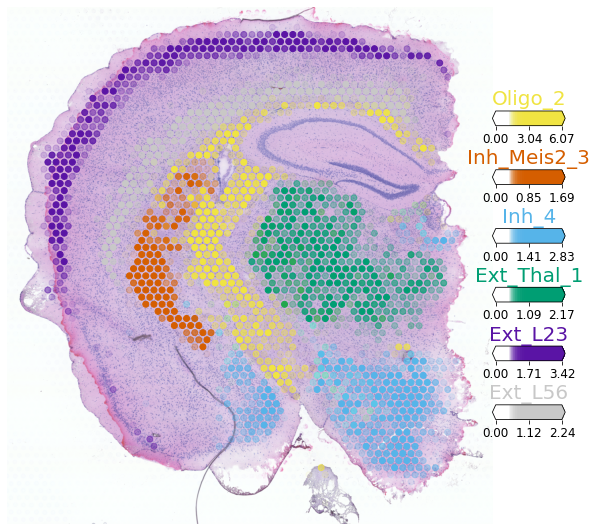

In [7]:
from cell2location.plt.mapping_video import plot_spatial

# select up to 6 clusters 
sel_clust = ['Oligo_2', 'Inh_Meis2_3', 'Inh_4', 'Ext_Thal_1', 'Ext_L23', 'Ext_L56']
sel_clust_col = ['q05_spot_factors' + str(i) for i in sel_clust]

def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.
    
    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """
    
    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}
    
    return slide

slide = select_slide(adata_vis, 'ST8059048')

# identify spot locations to crop near tissue
crop_max = (slide.obsm['spatial'] \
            * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).max(axis=0)
crop_min = (slide.obsm['spatial'] \
            * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef']).min(axis=0)

crop_x = [crop_min[0]-50, crop_max[0]+50]
crop_y = [crop_max[1]+20, crop_min[1]-20]

with mpl.rc_context({'figure.figsize': (10, 10)}):
    fig = plot_spatial(slide.obs[sel_clust_col], 
                  coords=slide.obsm['spatial'] \
                          * list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'], 
                  show_img=True, img_alpha=0.8,
                  img=list(slide.uns['spatial'].values())[0]['images']['hires'],
                  crop_x=crop_x, crop_y=[crop_y[1]] + [crop_y[0]],
                  circle_diameter=6, labels=sel_clust, colorbar_position='right')

In [8]:
from cell2location.plt.mapping_video import plot_video_mapping

In [ ]:
sel_spot_fact = slide.obs[sel_clust_col]
sel_spot_fact.columns = sel_clust
s = slide.obs['sample'][0]
model_folder = f'{sp_results_folder}{run_name}'

with mpl.rc_context({'figure.figsize': (10, 10),
                    'savefig.facecolor': 'black'}):
    plot_video_mapping(slide, 
                 adata_snrna_raw,
                 slide.obs['sample'], sel_spot_fact,
                 sel_clust, sel_clust,
                 sample_id=s, adata_cluster_col='annotation_1', cell_fact_df=None,
                 step_n=[20, 80, 15, 45, 80, 30],  # [2, 4, 3, 3, 2, 2] [20, 80, 15, 45, 80, 30]
                 step_quantile=[1, 1, 1, 1, 0.95, 0.95],
                 sc_point_size=1, aver_point_size=20, sp_point_size=6,
                 sc_alpha=0.6, sp_alpha=0.8, sc_power=20, sp_power=20, 
                 sc_accel_power=3, sp_accel_power=3, sc_accel_decel=True, sp_accel_decel=False,
                 sc_jitter=None, sp_jitter=None, adjust_text=False,
                 sp_img=list(slide.uns['spatial'].values())[0]['images']['hires'], 
                 sc_img=list(slide.uns['spatial'].values())[0]['images']['hires']*0,
                 sp_img_scaling_fac=list(slide.uns['spatial'].values())[0]['scalefactors']['tissue_hires_scalef'],
                 crop_x=crop_x, crop_y=[crop_y[1]] + [crop_y[0]],
                 save_path=model_folder+'/mapping_video/',
                 colorbar_shape={'vertical_gaps': 2, 'horizontal_gaps': 0.18})

model_folder+'/mapping_video/'

In [2]:
# install ffmpeg and zlib: conda activate cellpymcr3 && conda install -c conda-forge ffmpeg zlib
# use -r (rate) to adjust frames per second 
cd /nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 45 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct.mp4
cd /nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 45 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct.gif

/bin/sh: 1: ffmpeg: not found
cat: write error: Broken pipe
/bin/sh: 1: ffmpeg: not found
cat: write error: Broken pipe


In [2]:
# install ffmpeg and zlib: conda activate cellpymcr3 && conda install -c conda-forge ffmpeg zlib
# use -r (rate) to adjust frames per second 
cd /nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 60 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct_fast60.mp4
cd /nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/docs/notebooks/results/mouse_viseum_snrna/std_model/LocationModelLinearDependentWMultiExperiment_58clusters_5396locations_12809genes/mapping_video/ && cat `ls | sort -V` | ffmpeg -f image2pipe -r 60 -c:v png -i - -vf scale=1080:-2 -pix_fmt yuv420p ../mapping_video_distinct_fast60.gif

/bin/sh: 1: ffmpeg: not found
cat: write error: Broken pipe
/bin/sh: 1: ffmpeg: not found
cat: write error: Broken pipe


Modules and their versions used for this analysis

In [8]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(sys.modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass


sys 3.7.8 | packaged by conda-forge | (default, Jul 31 2020, 02:25:08) 
[GCC 7.5.0]
ipykernel 5.3.4
ipykernel._version 5.3.4
json 2.0.9
re 2.2.1
IPython 7.18.1
IPython.core.release 7.18.1
logging 0.5.1.2
zlib 1.0
traitlets 5.0.4
traitlets._version 5.0.4
argparse 1.1
ipython_genutils 0.2.0
ipython_genutils._version 0.2.0
platform 1.0.8
IPython.core.crashhandler 7.18.1
pygments 2.7.1
pexpect 4.8.0
ptyprocess 0.6.0
decorator 4.4.2
pickleshare 0.7.5
backcall 0.2.0
sqlite3 2.6.0
sqlite3.dbapi2 2.6.0
_sqlite3 2.6.0
prompt_toolkit 3.0.7
wcwidth 0.2.5
jedi 0.17.2
parso 0.7.1
colorama 0.4.3
ctypes 1.1.0
_ctypes 1.1.0
urllib.request 3.7
jupyter_client 6.1.7
jupyter_client._version 6.1.7
zmq 19.0.2
zmq.backend.cython 40302
zmq.backend.cython.constants 40302
zmq.sugar 19.0.2
zmq.sugar.constants 40302
zmq.sugar.version 19.0.2
jupyter_core 4.6.3
jupyter_core.version 4.6.3
distutils 3.7.8
tornado 6.0.4
_curses b'2.2'
dateutil 2.8.1
dateutil._version 2.8.1
six 1.15.0
decimal 1.70
_decimal 1.70
scanpy 